In [88]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.interpolate import CubicSpline

In [89]:
#os.chdir("/Users/natalyaradovic/Desktop/tau_shower_studies")
os.getcwd()

'/Users/natalyaradovic/Desktop/tau_shower_studies'

In [90]:
# Define constants
Earth_radius   = 6356.7523  # km, polar Earth radius
#Earth_radius = 6371 #km, Average Earth radius
tau_life_time  = 2.906e-13  # seconds
tau_mass       = 1776.82e6  # eV/c2
speed_of_light = 299792.458 # km / second
kB_W_Hz_K = 1.38064852e-23 # Watts / Hz / K

# Threshold voltage based on galactic noise and system temperature:
T_ice  = 270     # Kelvin (water temperature)
T_sys  = 140.     # System temperature at the lower part of the ANITA band from elog 119
kB     = 1.38e-23 # in Volts^2/Ohm/Hz/Kelvin
Z_0 = 377. # Ohms impedance of free space
Z_L = 50. # Ohms 50-Ohm characteristic impedance
Z_A = 50. # Ohms antenna impedance
frac_sky = 0.5 # fraction of sky visible to the antenna
#Gain_dB = 10. # antenna gain
#BW     = 400.e6   # bandwidth for first two ANITA bands.
#threshold_voltage = 8.9e-06 # V, this is 8.9 microVolts for sky temp 290 Kelvin T_sys
#threshold_voltage =np.sqrt(kB*(T_ant+T_sys)*Z_load*BW) # V, this is 8.22 microVolts for the parameters given above

In [91]:
detector_altitude = 1 # km
decay_altitude = 0.5  # km
zenith = 85

fi_efieldtd = "tau_showers/altitude_%2.1fkm_decay_%2.1fkm_zenith_%d.npz/efield_td.npy"%(detector_altitude, decay_altitude, zenith)
fi_efieldfd = "tau_showers/altitude_%2.1fkm_decay_%2.1fkm_zenith_%d.npz/efield_fd.npy"%(detector_altitude, decay_altitude, zenith)

In [92]:
efield_td = np.load(fi_efieldtd, allow_pickle=True,encoding="latin1")[None][0]
efield_fd = np.load(fi_efieldfd, allow_pickle=True,encoding="latin1")[None][0]

In [93]:
print(efield_td.keys())
print(efield_fd.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])


In [94]:
print(efield_td[25].keys())
print(efield_fd[25].keys())

dict_keys(['y_v_per_m', 'z_v_per_m', 'x_v_per_m', 'time_s'])
dict_keys(['freq_hz', 'x_v_per_m_Hz', 'z_v_per_m_Hz', 'y_v_per_m_Hz'])


0.29999999999388155


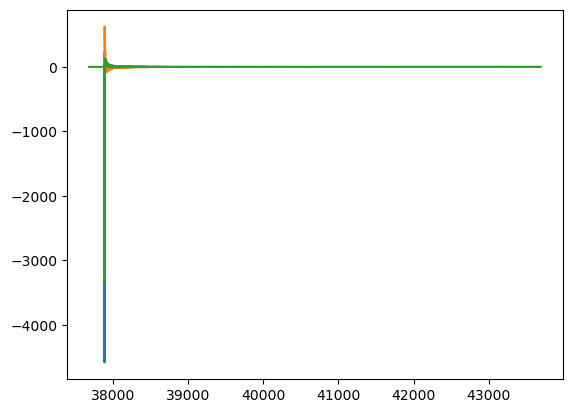

In [95]:
n = 2
plt.plot(efield_td[n]['time_s']*1e9, efield_td[n]['x_v_per_m']*1e6)
plt.plot(efield_td[n]['time_s']*1e9, efield_td[n]['y_v_per_m']*1e6)
plt.plot(efield_td[n]['time_s']*1e9, efield_td[n]['z_v_per_m']*1e6)
#plt.xlim(9700,9800)

print((efield_td[n]['time_s'][1]-efield_td[n]['time_s'][0])*1e9)

(0.0, 300.0)

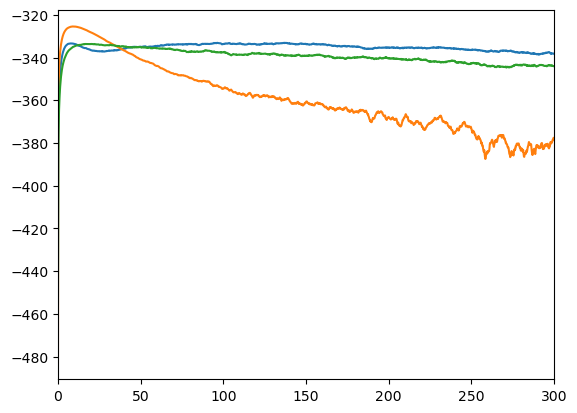

In [96]:
n = 2
plt.plot(efield_fd[n]['freq_hz']/1e6, 20*np.log10(efield_fd[n]['x_v_per_m_Hz']*1e6))
plt.plot(efield_fd[n]['freq_hz']/1e6, 20*np.log10(efield_fd[n]['y_v_per_m_Hz']*1e6))
plt.plot(efield_fd[n]['freq_hz']/1e6, 20*np.log10(efield_fd[n]['z_v_per_m_Hz']*1e6))
plt.xlim(0,300)

In [97]:
epeak_x = []
epeak_y = []
epeak_z = []

for i in range(0,80):
    ex = max(np.abs(efield_td[i]['x_v_per_m']*1e6))
    ey = max(np.abs(efield_td[i]['y_v_per_m']*1e6))
    ez = max(np.abs(efield_td[i]['z_v_per_m']*1e6))
    
    epeak_x.append(ex)
    epeak_y.append(ey)
    epeak_z.append(ez)

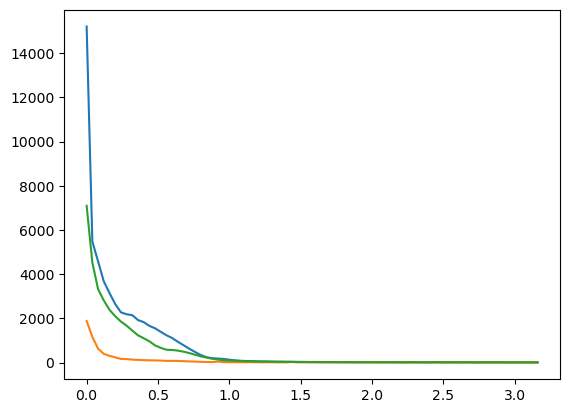

In [98]:
plt.plot(np.arange(0,80*0.04, 0.04), epeak_x)
plt.plot(np.arange(0,80*0.04, 0.04), epeak_y)
plt.plot(np.arange(0,80*0.04, 0.04), epeak_z)

In [99]:
def galactic_temperature(f_MHz):
    # Dulk 2001
    nu = f_MHz # Hz
    tau = 5.0 * pow(nu, -2.1)
    Ieg = 1.0610e-20
    Ig  = 2.48e-20
    # Iv in  W/m^2/Hz/sr
    Iv = Ig * pow(nu, -0.52) * (1-np.exp(-tau))/tau + Ieg * pow(nu, -0.80) * np.exp(-tau)
    
    kB = 1.38064852e-23 # Watts / Hz / K
    c = speed_of_light * 1e3 # m/s
    temp = Iv * c**2 / (2*(nu*1e6)**2)/kB
    ## IV is the intensity
    ## temp is the galactic noise temperature in Kelvin
    return Iv, temp # W/m^2/Hz/sr, K


In [100]:
Re = Earth_radius
def get_X0(
    zenith: np.ndarray, decay_altitude: np.ndarray, ice: float = 0.0
) -> np.ndarray:
    """
    Compute the location of X0 given the event parameters.
    See @swissel for details about this implementation.
    Parameters
    ----------
    ice: float
        The ice thickness in km.
    decay_altitude: np.ndarray
        The decay altitude in km.
    zenith: np.ndarray
        The zenith angle in degrees.
    """
    a = 1.0
    b = 2.0 * np.cos(np.deg2rad(zenith)) * (Re + ice)
    c = (Re + ice) ** 2 - (Re + ice + decay_altitude) ** 2
    X0 = (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    return X0

X0 = get_X0(zenith, decay_altitude, ice=0)
print('distance between exit and decay:' , X0)

def get_decay_zenith_angle(
    decay_altitude: np.ndarray, X0: np.ndarray, ice: float = 0.0
) -> np.ndarray:
    """
    Get the zenith angle at the decay point.
    See @swissel for details about this implementation.
    Parameters
    ----------
    decay_altitude: np.ndarray
        The decay altitude (in km).
    X0: np.ndarray
        The shower origin location.
    ice: float
        The thickness of the ice (km).
    """

    # get the quantities for the cosine rule
    A = X0
    B = Re + ice + decay_altitude
    C = Re + ice

    # construct cosz
    cosz = (A ** 2 + B ** 2 - C ** 2) / (2 * A * B)
    return np.rad2deg(np.arccos(cosz))

zenith_decay = get_decay_zenith_angle(decay_altitude,X0,ice=0)
print('decay zenith angle:', zenith_decay)

def get_view_angle(zenith: np.ndarray,zenith_decay: np.ndarray):
    view = zenith - zenith_decay
    return view

view = get_view_angle(zenith, zenith_decay)
print('view angle:', view)

def get_distance_decay_to_detector(
    zenith_decay: np.ndarray,
    view: np.ndarray,
    decay_altitude: np.ndarray,
    detector_altitude,
    ice: float = 0.0,
) -> np.ndarray:
    """
    Get the distance from the decay point to the detector.
    See @swissel for details on this implementation.
    Parameters
    ----------
    decay_altitude: np.ndarray
        The decay altitude (in km).
    detector_altitude:
        The altitude of the detector in (km).
    zenith_decay: np.ndarray
        The zenith angle at the decay (degrees)
    view: np.ndarray
        The view angle to the detector (degrees)
    ice: float
        The thickness of the ice (km).
    """
    a = 1
    b = 2 * np.cos(np.deg2rad(zenith_decay)) * (Re + ice + decay_altitude)
    c = (Re + ice + decay_altitude) ** 2 - (Re + detector_altitude) ** 2
    d = (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)

    dist = d/np.cos(np.deg2rad(view))
    return dist

dist_interp = get_distance_decay_to_detector(zenith_decay, view, decay_altitude, detector_altitude) * np.tan( np.arange(0.00, 0.04*80, 0.04) * np.pi/180.)
dist = get_distance_decay_to_detector(zenith_decay, view, decay_altitude, detector_altitude)
print('distance between decay and detection:', dist)

distance between exit and decay: 5.707681509615554
decay zenith angle: 84.94875432710789
view angle: 0.05124567289210802
distance between decay and detection: 5.650508647970814


Text(0.5, 1.0, 'Detector 1.0 km Decay 0.5 km Zenith 85$^\\circ$')

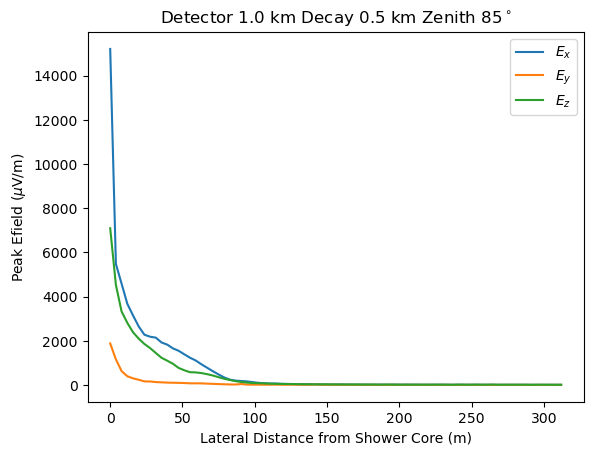

In [101]:
plt.plot(dist_interp*1e3, epeak_x, label="$E_x$")
plt.plot(dist_interp*1e3, epeak_y, label="$E_y$")
plt.plot(dist_interp*1e3, epeak_z, label="$E_z$")
plt.legend()
plt.xlabel("Lateral Distance from Shower Core (m)")
plt.ylabel("Peak Efield ($\mu$V/m)")
plt.title("Detector %1.1f km Decay %1.1f km Zenith %d$^\circ$"%(detector_altitude, decay_altitude, zenith))

(500.0, 1000.0)

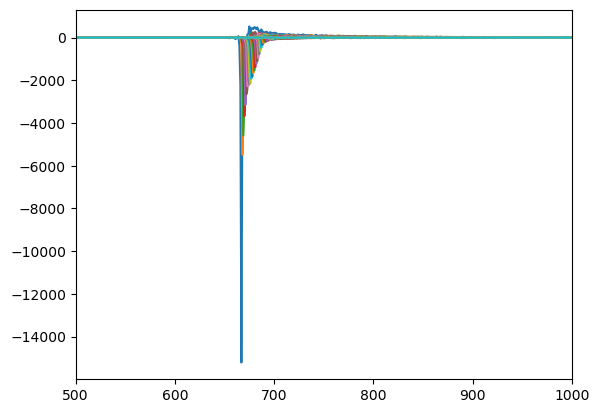

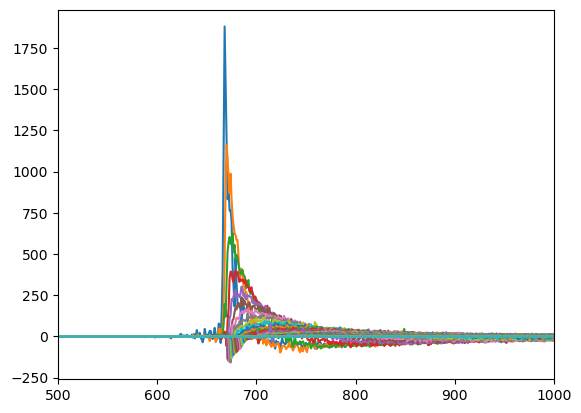

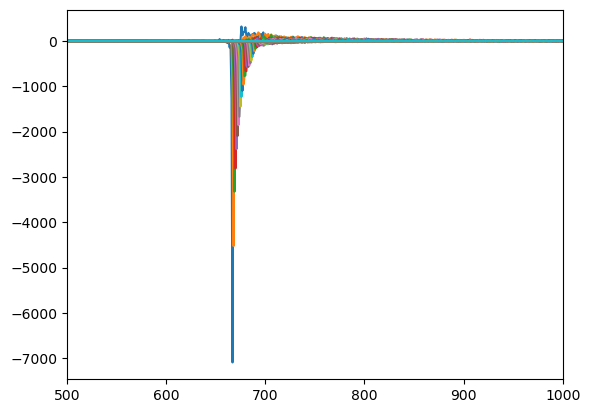

In [102]:
# Now try to coherently them up
for ant in range(80):
    view_angle = 0.04*ant
    plt.figure(1)
    plt.plot(efield_td[ant]['x_v_per_m']*1e6)
    plt.figure(2)
    plt.plot(efield_td[ant]['y_v_per_m']*1e6)
    plt.figure(3)
    plt.plot(efield_td[ant]['z_v_per_m']*1e6)
    
plt.figure(1)
plt.xlim(500,1000)

plt.figure(2)
plt.xlim(500,1000)

plt.figure(3)
plt.xlim(500,1000)

In [103]:
def get_dt(time, wave1, wave2):
    corr = signal.correlate(wave1, wave2, mode='full')
    peak_corr_ind = np.where(corr == max(abs(corr)))
    #print(len(time), len(corr), peak_corr_ind)
    #print(time[peak_corr_ind])
    return peak_corr_ind[0]#, time[peak_corr_ind]

def time_shift(wave, dt_index):
    shift_index = dt_index + 1
    return np.roll(wave, shift_index)

0.015209999863589563 0.015209999863589563 0.030419999727179126 0.030419999727179126


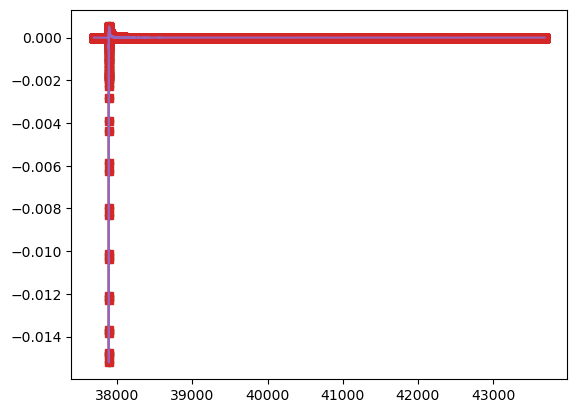

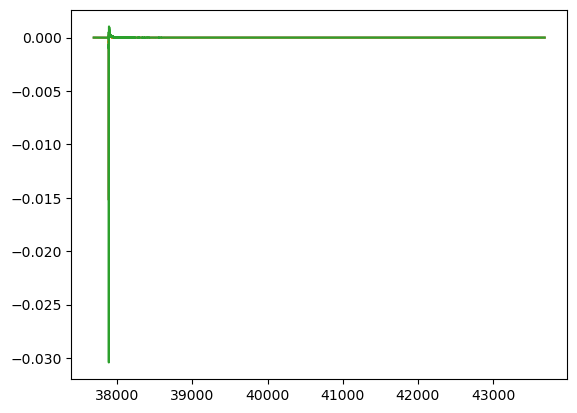

In [104]:
tm = efield_td[0]['time_s']
wave1 = efield_td[0]['x_v_per_m']
wave2 = efield_td[0]['x_v_per_m']

# upsample so we can better align
dt = tm[1] - tm[0]
tm_up = np.arange(min(tm), max(tm), dt/8.)
spl1 = CubicSpline(tm, wave1)
spl2 = CubicSpline(tm, wave2)
wave1_up = spl1(tm_up)
wave2_up = spl2(tm_up)

dt_index = get_dt(tm_up, wave1_up, wave2_up)
shift_wave2 = time_shift(wave2_up, dt_index)
phased_wave = wave1_up + shift_wave2

plt.figure(1)
plt.plot(efield_td[0]['time_s']*1e9, wave1)
plt.plot(efield_td[0]['time_s']*1e9, wave2)
plt.plot(tm_up*1e9, wave1_up, 'o')
plt.plot(tm_up*1e9, wave2_up, 's')
plt.plot(tm_up*1e9, shift_wave2)
#plt.xlim(19155,19180)

plt.figure(2)
plt.plot(tm_up*1e9, wave1_up)
plt.plot(tm_up*1e9, shift_wave2)
plt.plot(tm_up*1e9, phased_wave)
print(max(np.abs(wave1_up)), max(np.abs(shift_wave2)), max(np.abs(shift_wave2)) + max(np.abs(wave1_up)), max(np.abs(wave1_up + shift_wave2)))
#plt.xlim(19155,19180)

In [105]:
# find the peak 
max_ant = -999
max_ant_epeak = -999
for ant in range(80):
    epeak = max(np.abs(efield_td[ant]['x_v_per_m']))
    if epeak > max_ant_epeak:
        max_ant = ant
        max_ant_epeak = epeak
peak_wave = efield_td[max_ant]['x_v_per_m']
print(max_ant, max_ant_epeak)
        
# compare perfect phasing to not
ratio = []
dt_index_old=0
for ant in range(70):
    
    tm = efield_td[max_ant]['time_s']
    wave1 = peak_wave
    wave2 = efield_td[ant]['x_v_per_m']

    # upsample so we can better align
    dt = tm[1] - tm[0]
    tm_up = np.arange(min(tm), max(tm), dt/8.)
    spl1 = CubicSpline(tm, wave1)
    spl2 = CubicSpline(tm, wave2)
    wave1_up = spl1(tm_up)
    wave2_up = spl2(tm_up)

    dt_index = get_dt(tm_up, wave1_up, wave2_up)
    if dt_index == None or dt_index > len(tm_up):
        dt_index = dt_index_old
    shift_wave2 = time_shift(wave2_up, dt_index)
    sum_wave = wave1_up + shift_wave2
    peak_phased = max(np.abs(sum_wave))
    dt_index_old = dt_index
    
    r = peak_phased / (max_ant_epeak * 2.) 
    #print(peak_phased, max_ant_epeak * np.sqrt(2), r)
    
    ratio.append( r )

0 0.015209999867


0.0


(0.0, 200.0)

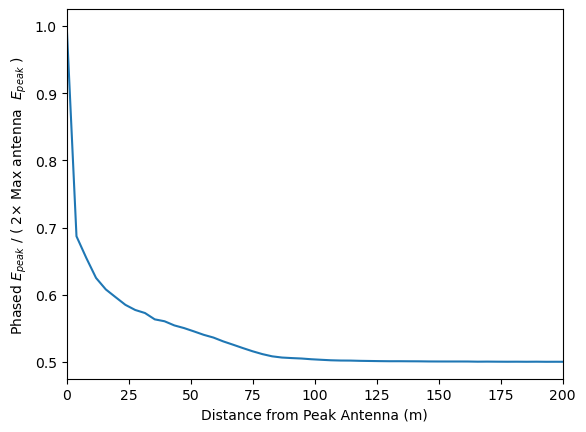

In [106]:
plt.plot(dist_interp[:70]*1e3 - dist_interp[max_ant]*1e3, ratio, "-")
plt.xlabel("Distance from Peak Antenna (m)")
plt.ylabel(r"Phased $E_{peak}$ / ( 2$\times$ Max antenna  $E_{peak}$ ) ")
plt.xlim(0,200)
print(dist_interp[max_ant]*1e3)
plt.xlim()